In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
from os import path

## Loading and Cleaning Data
We load our data using the ProgSnap2Dataset class. This comes with both a main event table and a LinkTable giving students final exam data.

In [2]:
semester = 'S19'
PATH = "data/CodeWorkout/" + semester

In [3]:
data = ProgSnap2Dataset(PATH)

In [4]:
# Drop the attempt column, since it's calculated incorrectly
data.drop_main_table_column('Attempt')

In [5]:
main_table = data.get_main_table()
student_table = data.load_link_table('Subject')

In [6]:
main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
119630,119630,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:13:03,UTC,CS 1,1,439.0,1,efdf3fae54cdc0a09fb81fcfa365c5f843e837b0,True,Run.Program,1.00,NaN,NaN,NaN,1-69176,NaN,NaN
119631,119631,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:13:03,UTC,CS 1,1,439.0,1,efdf3fae54cdc0a09fb81fcfa365c5f843e837b0,True,Compile,NaN,Success,NaN,NaN,1-69177,1-69176,NaN
134330,134330,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:13:33,0,CS 1,1,439.0,3,79b2bcc8f502e1f7d2d4e83d1894964684c89b85,True,Run.Program,1.00,NaN,NaN,NaN,3-68089,NaN,NaN
134331,134331,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:13:33,0,CS 1,1,439.0,3,79b2bcc8f502e1f7d2d4e83d1894964684c89b85,True,Compile,NaN,Success,NaN,NaN,3-68090,3-68089,NaN
65666,65666,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:09:54,UTC,CS 1,1,439.0,5,2697d299e7c5992f557ce38d8a04345112a11af8,True,Run.Program,0.75,NaN,NaN,NaN,5-35681,NaN,NaN


### Fall 2019 Preprocessing

There were some differences between F19 and S19:
* In F19 there was an additional assignment (between Assignment 4 and 5), which only ~70% of students completed, likely additional optional practice. We will not use this assignment for prediction, since it is abnormal and not in S19. Since it comes in between the two assignments we are using for prediction, we simply remove it.
* In F19 the AssignmentIDs were renamed, so we will update their names
* In F19 2 ProblemIDs were renamed (though the solutions were unchanged), so we will update their names

In [7]:
print(len(main_table[PS2.AssignmentID].unique()))
print(len(main_table[PS2.ProblemID].unique()))

5
50


In [8]:
# This assignment has no analogue, but we use 500 to put it between the other 2
NEW_F19_ASSIGNMENT = 500

In [9]:
if semester == 'F19':
    assignment_map = {
        597: 439,
        600: 487,
        609: 492,
        615: 494,
        622: NEW_F19_ASSIGNMENT,
        631: 502,
    }
    print(np.mean(main_table[PS2.AssignmentID].isin(assignment_map)))
    main_table[PS2.AssignmentID] = main_table[PS2.AssignmentID].map(assignment_map)
    
    # Two problems were renamed but are equivalent
    problem_map = {problem_id: problem_id for problem_id in main_table[PS2.ProblemID].unique()}
    problem_map[736] = 45
    problem_map[737] = 48
    print(np.mean(main_table[PS2.ProblemID].isin(problem_map)))
    main_table[PS2.ProblemID] = main_table[PS2.ProblemID].map(problem_map, na_action='ignore')
    
    # Overwrite the main table so this is the one that's copied
    data.set_main_table(main_table)

In [10]:
print(len(main_table[PS2.AssignmentID].unique()))
print(len(main_table[PS2.ProblemID].unique()))

5
50


In [11]:
main_table[PS2.ProblemID]

119630      1
119631      1
134330      3
134331      3
65666       5
         ... 
108283     71
110202    112
110203    112
81273     118
81274     118
Name: ProblemID, Length: 201570, dtype: int64

### Filtering Students

Here we remove studens who did not take the final exam, since we cannot use these for Task 2 (final exam score prediction). While this does somewhat bias the dataset for Task 1, it also ensures a consistent set of training/testing students for both tasks.

We can also see that few students are actually removed this way (381 -> 348 for S19).

In [12]:
# Get the SubjectIDs where the final grade is non-0
# A 0 grade indicates the student did not take the final
print(len(student_table.index))
subject_ids = set(student_table[student_table['X-Grade'] != 0][PS2.SubjectID].unique())
subject_ids = subject_ids.intersection(set(student_table['SubjectID'].unique()))
len(subject_ids)

381


348

### EDA

We want to confirm that our selected students have a good and well-distributed number of attempts at all the problems in the dataset, and the most problems were well-attempted. The stats and figures below suggest that this is the case: most problems are attempted by ~300/350 students, and most students complete ~40/50 problems.

In [13]:
# First we check how many problems each student attempted
main_table_filtered = main_table[main_table[PS2.SubjectID].isin(subject_ids)]
problems_per_student = main_table_filtered.groupby(by=['SubjectID']).apply(lambda rows: len(rows[PS2.ProblemID].unique()))
# 75% of problems were attempted by at least 40 studens, so that's good
problems_per_student.describe()

count    346.000000
mean      42.855491
std       10.331712
min        1.000000
25%       40.000000
50%       48.500000
75%       50.000000
max       50.000000
dtype: float64

In [14]:
# Only 3 attempted fewer than 10 problems
sum(problems_per_student < 10)

3

In [15]:
# Next we see how many students attempted each problem
students_per_problem = main_table_filtered.groupby(by=['AssignmentID', 'ProblemID']).apply(lambda rows: len(rows[PS2.SubjectID].unique()))
students_per_problem.describe()

count     50.000000
mean     296.560000
std       14.642906
min      267.000000
25%      285.000000
50%      295.500000
75%      309.750000
max      324.000000
dtype: float64

<BarContainer object of 50 artists>

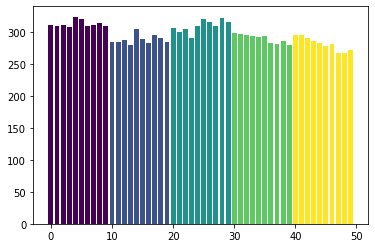

In [16]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

assignment_ids = list(students_per_problem.keys().map(lambda x: x[0]))
assignment_ids = [sorted(assignment_ids).index(x) for x in assignment_ids]
colors = [viridis((float(i)-min(assignment_ids))/(max(assignment_ids)-min(assignment_ids))) for i in assignment_ids]

# There's a slight drop-off by assignment, but overall they're well-attempted
plt.bar(range(0, len(students_per_problem)), students_per_problem, color=colors)

## Creating the Class Label: Identifying Struggling Students

In any student modeling task, our goal is to predict if a student will struggle on the next problem. For this dataset, it's not obvious how to define that struggle.

We will define struggle as either:
1. Never getting a problem correct or 
2. Taking more attempts at a problem than 75% of students before getting it correct.

The code below justifies this decision by showing that most students get the problem correct _eventually_, and most student with more than the 75th percentil of attempts end up with many more attempts than their peers, indicating struggle.

### Aggregate data by problem

We first get all scored submissions (`Run.Program` events) and aggregate them by SubjectID and ProblemID, counting the number of attempts until a correct submission.

In [17]:
runs = main_table_filtered[main_table_filtered[PS2.EventType] == 'Run.Program'].copy()
runs['TimeInt'] = pd.to_datetime(runs[PS2.ServerTimestamp]).apply(lambda x: x.value)

In [18]:
def get_attempts(rows):
    scores = rows[PS2.Score]
    # If they scored 1, we return the first time they did so
    if (scores.max() == 1):
        # Argmax returns the first index of the highest score
        # Since the array is 0-indexed, we return +1
        return rows[PS2.Score].argmax() + 1
    return len(rows.index)
    

scores = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_attempts)
scores.describe()

count    14828.000000
mean         4.196318
std          5.879822
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [19]:
# Confirm that this is different than just the count of runs
runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(lambda x: len(x.index)).describe()

count    14828.000000
mean         4.345090
std          6.076818
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [20]:
student_attempts = scores.to_frame('Attempts').reset_index()
print(student_attempts.shape)
student_attempts.head()

(14828, 4)


,SubjectID,AssignmentID,ProblemID,Attempts
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17


### Checking Eventual Success

Most student get each problem correct eventually, suggesting that the number of attempts is a more meaningful indicator of succeess.

In [21]:
correct_eventually = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID])[PS2.Score].apply(lambda x: max(x) == 1)

In [22]:
np.mean(correct_eventually)

0.9299973024008632

In [23]:
student_scores = student_attempts.merge(correct_eventually.to_frame('CorrectEventually'), on=[PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID])
student_scores

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True
...,...,...,...,...,...
14823,ffb72475a81de0e95b910ffad039f5c2,502.0,64,2,True
14824,ffb72475a81de0e95b910ffad039f5c2,502.0,70,2,True
14825,ffb72475a81de0e95b910ffad039f5c2,502.0,71,1,True
14826,ffb72475a81de0e95b910ffad039f5c2,502.0,112,1,True


In [24]:
student_scores.CorrectEventually.value_counts()

True     13790
False     1038
Name: CorrectEventually, dtype: int64

### Choosing a cutoff for "struggling"
We choose the 75th percentile of attempts as the cutoff for struggling, and visualize this to verify that it meaningfully separates the "tail" of more struggling students from the main body. The chart below shows this for all 50 problems, and suggests that this is a reasonable (though by no means objectively correct) cutoff.

In [25]:
problem_attempt_75th = student_scores.groupby(PS2.ProblemID).apply(lambda x: x.Attempts.quantile(0.75))
problem_attempt_75th.head()

ProblemID
1      2.0
3      4.0
5      4.0
12     2.0
13    11.0
dtype: float64

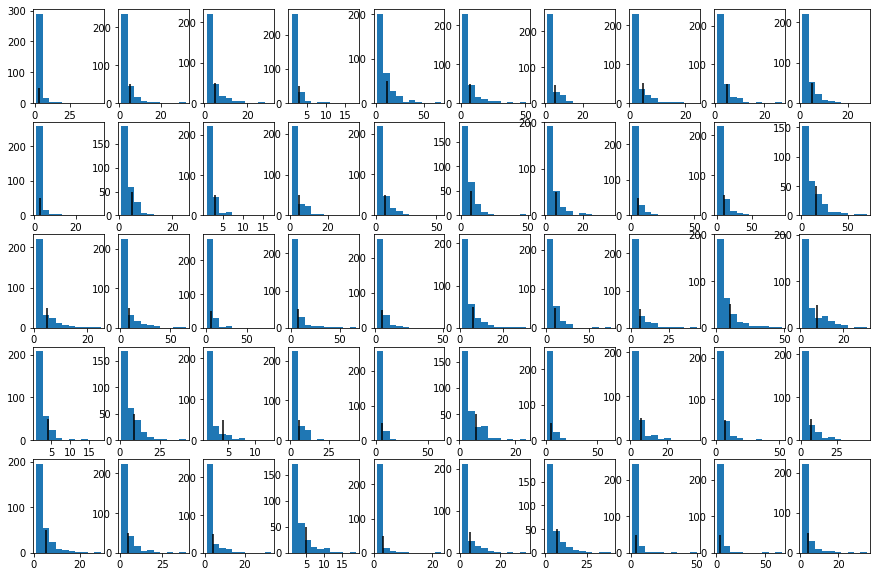

In [26]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

problem_ids = list(student_scores.ProblemID.unique())
fig, axs = plt.subplots(5, 10)
for i in range(5):
    for j in range(10):
        problem_id = problem_ids[i * 10 + j]
        attempts = student_scores[student_scores[PS2.ProblemID] == problem_id].Attempts
        p75 = problem_attempt_75th[problem_id] + 1
        axs[i, j].hist(attempts)
        axs[i, j].vlines(p75, 0, 50)

In [27]:
cutoffs = student_scores['ProblemID'].apply(lambda x: problem_attempt_75th[x])
student_scores['Label'] = np.logical_and(student_scores['Attempts'] <= cutoffs, student_scores['CorrectEventually'])
student_scores['Label'].value_counts()

True     10931
False     3897
Name: Label, dtype: int64

(array([ 3.,  2.,  8., 13., 24., 38., 56., 46., 65., 91.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

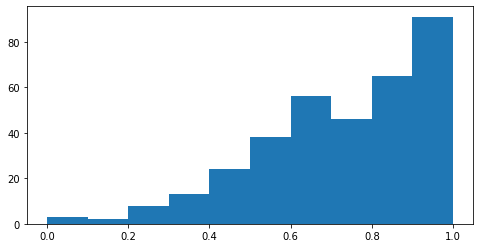

In [28]:
matplotlib.rcParams['figure.figsize'] = [8, 4]

# The percentage of struggling problems per student is well-distributed
plt.hist(student_scores.groupby(PS2.SubjectID)['Label'].mean())

## Identifying Late Assignments

Below we confirm that the 5 assignments are well-spaced out, with a consistent ordering accross students.

The latter 2 assignments are what is predicted in Task 1 of the data challenge.

We divide the data by assignment, rather than by problem, since within a given assignment studens do problems in a variety of orders (see analysis at the end of this document).

In [29]:
problem_times = runs.groupby([PS2.AssignmentID, PS2.ProblemID])['TimeInt'].median()
start_time = min(problem_times)
problem_times = (problem_times - start_time) / 10**9

problem_successes = runs[runs[PS2.Score] == 1].groupby([PS2.AssignmentID, PS2.ProblemID])['TimeInt'].median()
problem_successes = (problem_successes - start_time) / 10**9

In [30]:
problem_stats = problem_times.to_frame('MedTime').join(problem_successes.to_frame('MedSuccess')).reset_index()
problem_stats.head()

,AssignmentID,ProblemID,MedTime,MedSuccess
0,439.0,1,10500.0,8412.0
1,439.0,3,8683.0,10464.0
2,439.0,5,5753.0,6900.5
3,439.0,12,3844.5,7733.5
4,439.0,13,0.0,2022.5


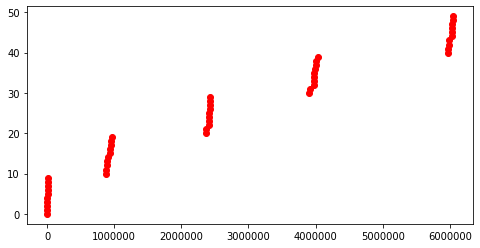

In [31]:
y = range(0, len(problem_stats.index))
problem_stats.sort_values('MedTime', inplace=True)
plt.scatter(problem_stats['MedTime'], y, c='red')
# plt.scatter(problem_stats['MedSuccess'], y, c='blue')

In [32]:
# Assignments are, thankfully, already in order
assignment_stats = runs.groupby(PS2.AssignmentID).apply(lambda x: np.median(x['TimeInt']))
assignment_stats

AssignmentID
439.0    1.551040e+18
487.0    1.551934e+18
492.0    1.553453e+18
494.0    1.555015e+18
502.0    1.557066e+18
dtype: float64

In [33]:
valid_assignments = list(assignment_stats.sort_values().index)
if (semester == 'F19'):
    valid_assignments.remove(NEW_F19_ASSIGNMENT)
valid_assignments

[439.0, 487.0, 492.0, 494.0, 502.0]

In [34]:
late_assignments = valid_assignments[-2:]
late_assignments

[494.0, 502.0]

In [35]:
early_assignments = valid_assignments[:-2]
early_assignments

[439.0, 487.0, 492.0]

In [36]:
student_scores['IsLateProblem'] = student_scores[PS2.AssignmentID].isin(late_assignments)
student_scores.sort_values([PS2.SubjectID, PS2.AssignmentID, 'IsLateProblem', PS2.ProblemID], inplace=True)
# Remove attempts not in a valid assignment (for F19)
student_scores = student_scores[student_scores[PS2.AssignmentID].isin(valid_assignments)]
student_scores.head(50)

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label,IsLateProblem
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True,False
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False,False
5,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,232,9,True,False,False
6,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,233,1,True,True,False
7,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,234,3,True,True,False
8,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,235,1,True,True,False
9,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,236,3,True,True,False


## Train/Test Split

Here we split out data into training/test datasets, as well as eary problems (used to extract features input into the model) and late problems (where struggle will be predicted).

### Split by SubjectID

In [37]:
# Valid subjects must have completed at least one early and one late problem
ealry_late_subject_ids = student_scores.groupby(PS2.SubjectID)['IsLateProblem'].apply(lambda x: np.mean(x) > 0 and np.mean(x) < 1)
# The vast majority of students have
np.mean(ealry_late_subject_ids)

0.9508670520231214

In [38]:
# Instersect these subjectIDs with the ones who completed the final exam
valid_subject_ids = subject_ids.intersection(set(ealry_late_subject_ids.index[ealry_late_subject_ids]))
valid_subject_ids = list(valid_subject_ids)
valid_subject_ids.sort()

In [39]:
print(len(subject_ids))
print(len(valid_subject_ids))

348
329


In [40]:
train_ids, test_ids = train_test_split(list(valid_subject_ids), test_size=0.25, random_state=1234)

In [41]:
# Check the train/test split dataframe against the last saved run
ids_df = pd.DataFrame({PS2.SubjectID: valid_subject_ids})
ids_df['IsTrain'] = ids_df[PS2.SubjectID].isin(train_ids)
ids_df

path = os.path.join('data', 'Release', semester)
os.makedirs(path, exist_ok=True)

# If saving, uncomment the top line
# ids_df.to_csv(os.path.join(path, 'split.csv'), index=False)
cached_df = pd.read_csv(os.path.join(path, 'split.csv'))

assert(ids_df.equals(cached_df))

In [42]:
print(len(train_ids))
print(len(test_ids))

246
83


In [43]:
student_scores_train = student_scores[student_scores[PS2.SubjectID].isin(train_ids)]
student_scores_test = student_scores[student_scores[PS2.SubjectID].isin(test_ids)]

In [44]:
print(student_scores.shape[0])
print(student_scores_train.shape[0])
print(student_scores_test.shape[0])

14828
10843
3738


### Task 1: Split Into early/late datasets
In Task 1, we need an early set of problems to use to extract features for the model, and a late set of problems where we're actually predicting student outcomes.

In [45]:
early_train = student_scores_train[student_scores_train['IsLateProblem'] == False].drop(['IsLateProblem'], axis=1)
early_test = student_scores_test[student_scores_test['IsLateProblem'] == False].drop(['IsLateProblem'], axis=1)
late_train = student_scores_train[student_scores_train['IsLateProblem']].drop(['IsLateProblem', 'Attempts', 'CorrectEventually'], axis=1)
late_test = student_scores_test[student_scores_test['IsLateProblem']].drop(['IsLateProblem', 'Attempts', 'CorrectEventually'], axis=1)

In [46]:
print(early_train.shape)
early_train.head()

(6642, 6)


,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
50,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
51,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
52,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
53,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
54,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [47]:
print(early_test.shape)
early_test.head()

(2227, 6)


,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False


In [48]:
print(late_train.shape)
late_train.head()

(4201, 4)


,SubjectID,AssignmentID,ProblemID,Label
80,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
81,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
82,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
83,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
84,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [49]:
print(late_test.shape)
late_test.head()

(1511, 4)


,SubjectID,AssignmentID,ProblemID,Label
30,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,True
31,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,False
32,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,False
33,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,False
34,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,False


In [50]:
base_path = os.path.join('data', 'Release', semester)
os.makedirs(os.path.join(base_path, 'Train'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'Test'), exist_ok=True)

In [51]:
early_train.to_csv(os.path.join(base_path, 'Train', 'early.csv'), index=False)
late_train.to_csv(os.path.join(base_path, 'Train', 'late.csv'), index=False)
early_test.to_csv(os.path.join(base_path, 'Test', 'early.csv'), index=False)
late_test.drop('Label', axis=1).to_csv(os.path.join(base_path, 'Test', 'late.csv'), index=False)

In [52]:
data.save_subset(os.path.join(base_path, 'Train', 'Data'), lambda df: df[df[PS2.SubjectID].isin(train_ids) & df[PS2.AssignmentID].isin(valid_assignments)])

In [53]:
data.save_subset(os.path.join(base_path, 'Test', 'Data'), lambda df: df[df[PS2.SubjectID].isin(test_ids) & df[PS2.AssignmentID].isin(early_assignments)], False)

### Task 2: Predicting Student Grades
For Task 2, we are predicting students' Final Exam grades. We just add the appropriate LinkTable _without_ the actual grades, just leaving the SubjectIDs to predict for.

In [54]:
student_table_dir = os.path.join(base_path, 'Test', 'Data', 'LinkTables')
os.makedirs(student_table_dir, exist_ok=True)
student_table_test = student_table[student_table[PS2.SubjectID].isin(test_ids)]
student_table_test.drop('X-Grade', axis=1).to_csv(os.path.join(student_table_dir, 'Subject.csv'), index=False)

### Save the solution
The solution is, of course, not released, but used to judge submissions.

In [55]:
sol_path = os.path.join('data', 'Solution', semester, 'task1', 'ref')
os.makedirs(sol_path, exist_ok=True)
late_test.to_csv(os.path.join(sol_path, 'truth.csv'), index=False)

In [56]:
sol_path = os.path.join('data', 'Solution', semester, 'task2', 'ref')
os.makedirs(sol_path, exist_ok=True)
student_table_test.to_csv(os.path.join(sol_path, 'truth.csv'), index=False)

## Unused code for identifying the late problems

The code below was used to investigate whether we could predict the last 3 problems of every assignment using the first 7. However, students appear to do the assignment in a variety of orders, making this difficult. Additionally, this would leak future data (e.g. the first 7 problems on Assignment 2 could be used to predict the last 3 problems on Assignment 1).

In [57]:
def get_start_end_order(rows):
    return pd.Series({
        'StartEventOrder': min(rows[PS2.Order])
        # 'EndEventOrder': max(rows[PS2.Order])
    })

start_orders = main_table_filtered.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_start_end_order)
start_orders

StartEventOrder
SubjectID                        AssignmentID ProblemID                 
036ad3e516c5bf3a4b3be35b137bcbb8 439.0        1                   120635
                                              3                   135624
                                              5                    66827
                                              12                   37923
                                              13                   30588
...                                                                  ...
ffb72475a81de0e95b910ffad039f5c2 502.0        64                   49816
                                              70                  113478
                                              71                  108282
                                              112                 110202
                                              118                  81273

[14828 rows x 1 columns]

[439. 487. 492. 494. 502.]


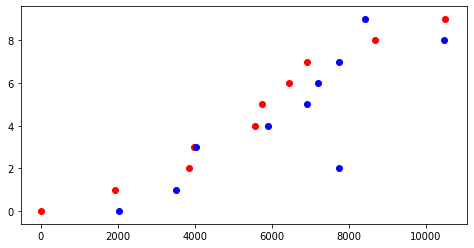

In [58]:
# Unfortunately, the last 3 problems aren't always easy to pick apart
print(problem_stats[PS2.AssignmentID].unique())
assignment1 = problem_stats[problem_stats[PS2.AssignmentID] == 439]
y = range(0, 10)
plt.scatter(assignment1['MedTime'], y, c='red')
plt.scatter(assignment1['MedSuccess'], y, c='blue')

In [59]:
late_problems = problem_stats.groupby(PS2.AssignmentID).apply(lambda rows: list(rows[PS2.ProblemID][rows['MedTime'].argsort()][-3:]))
late_problems

AssignmentID
439.0    [234, 235, 236]
487.0      [25, 101, 28]
492.0       [36, 38, 32]
494.0      [44, 46, 106]
502.0      [70, 71, 112]
dtype: object

In [60]:
late_problem_ids_old = [st for row in late_problems for st in row]
late_problem_ids_old

[234, 235, 236, 25, 101, 28, 36, 38, 32, 44, 46, 106, 70, 71, 112]

In [61]:
runs_time = runs.copy()
runs_time['IsLateProblemInAssignment'] = runs_time[PS2.ProblemID].isin(late_problem_ids_old)
runs_time.head(15)

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,CodeStateID,...,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation,TimeInt,IsLateProblemInAssignment
120635,120635,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:27:58,UTC,CS 1,1,439.0,1,936875daafdf59534e6d3ffc51aa4f550d527dcc,...,Run.Program,0.000000,NaN,NaN,NaN,1-70192,NaN,NaN,1551058078000000000,False
120638,120638,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:28:27,UTC,CS 1,1,439.0,1,af14542df004a5ebc1b726f0adcdc769cd42b18e,...,Run.Program,0.000000,NaN,NaN,NaN,1-70195,NaN,NaN,1551058107000000000,False
120641,120641,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:28:31,UTC,CS 1,1,439.0,1,386ea403fed8cca55f27dd511918fcb4353bfb3a,...,Run.Program,0.466667,NaN,NaN,NaN,1-70198,NaN,NaN,1551058111000000000,False
120645,120645,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:29:06,UTC,CS 1,1,439.0,1,9269580e3704c32cd066eb466ef6d7d97cd426e1,...,Run.Program,0.333333,NaN,NaN,NaN,1-70202,NaN,NaN,1551058146000000000,False
120655,120655,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:29:29,UTC,CS 1,1,439.0,1,e7793eddc2d7caee087c45aa9a886712193a0879,...,Run.Program,0.733333,NaN,NaN,NaN,1-70212,NaN,NaN,1551058169000000000,False
120661,120661,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:30:11,UTC,CS 1,1,439.0,1,c394cc24e5739dce498d4fbe79e7d613bfd58a9e,...,Run.Program,0.000000,NaN,NaN,NaN,1-70218,NaN,NaN,1551058211000000000,False
120669,120669,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:30:28,UTC,CS 1,1,439.0,1,7e2f9baefd114d950bf34c0601499ba5a56e79ac,...,Run.Program,0.000000,NaN,NaN,NaN,1-70226,NaN,NaN,1551058228000000000,False
120687,120687,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:30:43,UTC,CS 1,1,439.0,1,e0550ffae869df0caa551c0f84b18472ef48b257,...,Run.Program,1.000000,NaN,NaN,NaN,1-70244,NaN,NaN,1551058243000000000,False
135624,135624,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:36:04,0,CS 1,1,439.0,3,5044ac4abdd24172cb1da80ff3285e05679e2f9a,...,Run.Program,0.562500,NaN,NaN,NaN,3-69396,NaN,NaN,1551058564000000000,False
135626,135626,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-02-25T01:36:55,0,CS 1,1,439.0,3,c9a763ed9b799ef1ed39f9a66a4393cad5ab2720,...,Run.Program,0.000000,NaN,NaN,NaN,3-69398,NaN,NaN,1551058615000000000,False


In [62]:
first_late_attempts = runs_time[runs_time['IsLateProblemInAssignment']].groupby([PS2.AssignmentID, PS2.SubjectID])['TimeInt'].min()
first_late_attempts

AssignmentID  SubjectID                       
439.0         036ad3e516c5bf3a4b3be35b137bcbb8    1551056564000000000
              04c32d4d95425f73b3a1d6502aed4d48    1550958319000000000
              0503bf609757acf2e75aa8cbc0d8323b    1551067824000000000
              06d801cb636235b298c40029ad9921e7    1551058104000000000
              07ae4cca3f90a49347ccb5c1a82ff46f    1551055620000000000
                                                         ...         
502.0         f892447540d0e840049183faa3109b1b    1556916367000000000
              fa28c6cdf8dd6f41a657c3d7caa5c709    1556680214000000000
              fda6baab618b39821b678bd52ff26428    1557101932000000000
              feae21bb32b7b4aa690fab151b60b598    1556755423000000000
              ffb72475a81de0e95b910ffad039f5c2    1557099701000000000
Name: TimeInt, Length: 1514, dtype: int64

In [63]:
runs_late = runs_time.merge(first_late_attempts.to_frame('FirstLateAttempt'), on=[PS2.AssignmentID, PS2.SubjectID], how='left')
np.mean(runs_late['FirstLateAttempt'].isna())
# ~2% of student-assignments did not have a late attempt

0.007046516320290552

In [64]:
runs_late['IsLateAttempt'] = runs_late['TimeInt'] >= runs_late['FirstLateAttempt']

In [65]:
np.sum(~runs_late['IsLateAttempt'] & runs_late['IsLateProblemInAssignment'])

0

In [66]:
# 30% of attempts at early problems occurred after the first attempt at a late problem
np.sum(runs_late['IsLateAttempt'] & ~runs_late['IsLateProblemInAssignment']) / np.sum(~runs_late['IsLateProblemInAssignment'])

0.5820590770906121

In [67]:
np.random.seed(1234)
subjects_sample = np.random.choice(runs_time[PS2.SubjectID].unique(), 20)
assignment_sample = runs_time[(runs_time[PS2.AssignmentID] == 439) & runs_time[PS2.SubjectID].isin(subjects_sample)]
assignment_sample.shape

(742, 21)

(-2, 2)

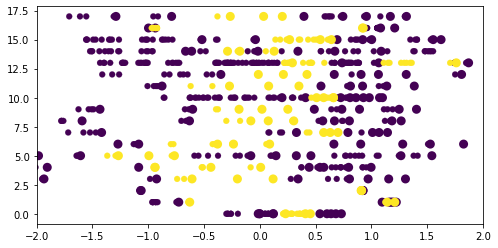

In [68]:
all_subject_ids = assignment_sample[PS2.SubjectID]
distinct_subject_ids = all_subject_ids.unique()
subject_indices = [sorted(distinct_subject_ids).index(x) for x in all_subject_ids]
colors = [viridis(float(i)) for i in assignment_sample['IsLateProblemInAssignment']]
subject_times_norm = assignment_sample.groupby('SubjectID')['TimeInt'].transform(lambda x: (x - x.mean()) / x.std())
widths = list(assignment_sample[PS2.Score].apply(lambda x: 0.2 if x < 1 else 3))
plt.scatter(x=subject_times_norm, y=subject_indices, color=colors, linewidths=widths, edgecolors=None)
plt.xlim([-2, 2])

In [69]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])

def is_consistent(rows):
    orders = rows[PS2.Order]
    times = rows['TimeInt']
    return is_sorted(times.values)

consistent = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(is_consistent)
consistent

SubjectID                         AssignmentID  ProblemID
036ad3e516c5bf3a4b3be35b137bcbb8  439.0         1            True
                                                3            True
                                                5            True
                                                12           True
                                                13           True
                                                             ... 
ffb72475a81de0e95b910ffad039f5c2  502.0         64           True
                                                70           True
                                                71           True
                                                112          True
                                                118          True
Length: 14828, dtype: bool

In [70]:
runs[(runs[PS2.ProblemID]==102) & (runs[PS2.SubjectID]=='71ffa17407d66e134442eebb32d330ec')]

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation,TimeInt
124457,124457,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:38:14,0,CS 1,2,487.0,102,42e1f3bb1091f9eec2eb577ab96bae4957968995,True,Run.Program,0.307692,NaN,NaN,NaN,102-77705,NaN,NaN,1551717494000000000
124486,124486,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:41:05,0,CS 1,2,487.0,102,169c7b05ae34784131e2d28d4405ebc555b18809,True,Run.Program,0.307692,NaN,NaN,NaN,102-77734,NaN,NaN,1551717665000000000
124488,124488,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:41:40,0,CS 1,2,487.0,102,16d28c968835cc078571422195034b7f4eb0e672,True,Run.Program,0.000000,NaN,NaN,NaN,102-77736,NaN,NaN,1551717700000000000
124490,124490,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:42:05,0,CS 1,2,487.0,102,6d2a1a03feb289d71573ff99c5b5d6f82a4e4c51,True,Run.Program,0.461538,NaN,NaN,NaN,102-77738,NaN,NaN,1551717725000000000
124492,124492,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:42:31,0,CS 1,2,487.0,102,58a1ff5e49eef11f50693100868942e82f901a7a,True,Run.Program,0.000000,NaN,NaN,NaN,102-77740,NaN,NaN,1551717751000000000
124495,124495,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:42:38,0,CS 1,2,487.0,102,df0c582539e719456d0affac2f532cd757397b74,True,Run.Program,0.000000,NaN,NaN,NaN,102-77743,NaN,NaN,1551717758000000000
124517,124517,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:45:34,0,CS 1,2,487.0,102,d4d60d8a83db04f7860a8a5e253cc5a688aff00a,True,Run.Program,0.000000,NaN,NaN,NaN,102-77765,NaN,NaN,1551717934000000000
124521,124521,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:45:52,0,CS 1,2,487.0,102,e14ab004b5288fdd5c76f285894dd3c1388f2500,True,Run.Program,0.461538,NaN,NaN,NaN,102-77769,NaN,NaN,1551717952000000000
124523,124523,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:45:51,0,CS 1,2,487.0,102,1d35d54dff4b63c48bb630cd45fceadc787a7e14,True,Run.Program,0.461538,NaN,NaN,NaN,102-77771,NaN,NaN,1551717951000000000
124525,124525,71ffa17407d66e134442eebb32d330ec,Java 8; CodeWorkout,2019-03-04T16:48:26,0,CS 1,2,487.0,102,fcff0609e46a63926def21d845edf14dc22bc259,True,Run.Program,0.000000,NaN,NaN,NaN,102-77773,NaN,NaN,1551718106000000000


In [71]:
consistent[~consistent]

SubjectID                         AssignmentID  ProblemID
71ffa17407d66e134442eebb32d330ec  487.0         102          False
81a0c4689fb7ce553a0d5c2fd19b6efd  439.0         233          False
a36d22467b9c3af222b5e231e3b23791  439.0         13           False
dtype: bool